In [89]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)
import re
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')

sub = pd.read_csv('sample_submission.csv')

In [ ]:
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')

### Merge on Transaction ID

In [13]:
# x_train = train_transaction.merge(train_identity, how='left',left_index=True,right_index=True)

In [14]:
# x_train.head()

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionID_y,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987004.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987008.0,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987010.0,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987011.0,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2987016.0,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


### Reduce Memory

In [3]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > df[col].astype(np.int64) and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        else:
                        df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df 

In [4]:
reduce_mem_usage(train_transaction)
reduce_mem_usage(train_identity)

Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.02 MB
Decreased by 77.8%


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0000,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0000,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0000,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0000,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0000,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,100.0000,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.0000,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0000,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0000,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [3]:
y_train = train_transaction.isFraud
train_transaction = train_transaction.drop('isFraud', axis=1)

#### Metrics we are mostly considering

#### Precision:#####
the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.

#### Recall: 
the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.

F1 Score: the weighted average of precision and recall.

# EDA

In [5]:
print(train_transaction.shape)
print(train_identity.shape)

(590540, 394)
(144233, 41)


Text(0.5, 1.0, 'Fraud Count   0:No Fraud     1:Fraud')

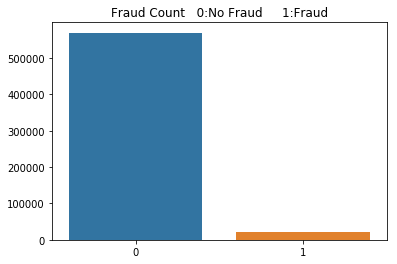

In [4]:
fraud_balance=train_transaction['isFraud'].value_counts().values
#y gives an arry of the value counts
sns.barplot([0,1],fraud_balance).set_title('Fraud Count   0:No Fraud     1:Fraud')

##### We see big class imbalance

### SMOTE only takes in numerical/ordinal. need to one hot encode

In [4]:
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [22]:
for train_index, test_index in tscv.split(train_transaction):
    print("TRAIN:", train_index, "TEST:", test_index)

     #To get the indices 
    X_train, X_test = train_transaction[train_index], train_transaction[test_index]
    y_train, y_test = y_train[train_index], y_train[test_index]


TRAIN: [    0     1     2 ... 98422 98423 98424] TEST: [ 98425  98426  98427 ... 196845 196846 196847]


KeyError: "None of [Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,\n                9,\n            ...\n            98415, 98416, 98417, 98418, 98419, 98420, 98421, 98422, 98423,\n            98424],\n           dtype='int64', length=98425)] are in the [columns]"

### separating data fraud no fraud

In [24]:
fraud = train_transaction.isFraud==1
no_fraud =train_transaction.isFraud==0

In [24]:
sm = SMOTE(ratio='minority', k_neighbors=13)
train_transaction, y_train = sm.fit_sample(train_transaction, y_train)

ValueError: could not convert string to float: 'W'

In [ ]:
plot_2d_space(X_sm, y_sm,X,y, 'SMOTE over-sampling')

In [41]:
train_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card_type,card5,card_category,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,...,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,domain_p,end_domain_p,foreign_p,domain_r,end_domain_r,foreign_r,Transaction_time_days
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,yes,1.000000
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gmail,.com,no,NaN,NaN,yes,1.000012
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,outlook,.com,no,NaN,NaN,yes,1.000799
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,T,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yahoo,.com,no,NaN,NaN,yes,1.001146
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gmail,.com,no,NaN,NaN,yes,1.001227


## Transaction EDA

In [29]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,...,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Exploring missing data

In [74]:
na_reps = ['dist2','D7','D13','D14','D12','D6','D8','D9','V142','V312']
train_transaction[na_reps].isna().sum().sort_values(ascending=False)

dist2    552913
D7       551623
D13      528588
D14      528353
D12      525823
D6       517353
D9       515614
D8       515614
V142     508595
V312         12
dtype: int64

In [86]:
reps_per = (train_transaction[na_reps].isna().sum()/len(train_transaction))*100
reps_per = pd.DataFrame({'Percent Missing':reps_per})
reps_per

,Percent Missing
dist2,93.628374
D7,93.409930
D13,89.509263
D14,89.469469
D12,89.041047
D6,87.606767
D8,87.312290
D9,87.312290
V142,86.123717
V312,0.002032


In [68]:
to_drop = (train_transaction.isna().sum()/len(train_transaction)>.60)
train_transaction = train_transaction.loc[:, ~to_drop]

In [109]:
train_transaction.isna().sum()/len(train_transaction)

TransactionID     0.000000
TransactionDT     0.000000
TransactionAmt    0.000000
ProductCD         0.000000
card1             0.000000
card2             0.015127
card3             0.002650
card4             0.002670
card5             0.007212
card6             0.002660
addr1             0.111264
addr2             0.111264
dist1             0.596524
P_emaildomain     0.159949
C1                0.000000
C2                0.000000
C3                0.000000
C4                0.000000
C5                0.000000
C6                0.000000
C7                0.000000
C8                0.000000
C9                0.000000
C10               0.000000
C11               0.000000
C12               0.000000
C13               0.000000
C14               0.000000
D1                0.002149
D2                0.475492
D3                0.445149
D4                0.286047
D5                0.524674
D10               0.128733
D11               0.472935
D15               0.150901
M1                0.459071
M

In [8]:
missing = [col for col in train_transaction.columns if not col.startswith('V')]
# cols_with_missing_vals = train_transaction.columns[train_transaction.isnull().sum() > 0]
missing_corr = train_transaction[missing].isnull().corr()
missing_corr = pd.DataFrame(missing_corr)

def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # create a triangular mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(14,8))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()
    

plot_null_correlations(train_transaction)

TypeError: 'module' object is not callable

### Isolating all unambiguous features to help with imputation

In [5]:
unambiguous = [col for col in train_transaction.columns if not col.startswith(('V','C','M','D'))]
train_transaction[unambiguous].head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN


In [ ]:
corr = train_transaction[unambiguous].corr(y_train)

### Splitting/cleaning/engineering from email domains

In [50]:
print(train_transaction['P_emaildomain'].isna().sum())
print(train_transaction['R_emaildomain'].isna().sum())

94456
453249


In [17]:
train_transaction['P_emaildomain'].value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
windstream.net         305
roadrunner.com         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

In [6]:
pattern = r"(?P<domain>[\w]+)(?P<end_domain>[\.\w+]+)"
url_parts_p = train_transaction['P_emaildomain'].str.extract(pattern, flags=re.I)
url_parts_r = train_transaction['R_emaildomain'].str.extract(pattern, flags=re.I)

In [56]:
url_parts_p.head(50)

,domain,end_domain
0,NaN,NaN
1,gmail,.com
2,outlook,.com
3,yahoo,.com
4,gmail,.com
5,gmail,.com
6,yahoo,.com
7,mail,.com
8,anonymous,.com
9,yahoo,.com


In [7]:
l = url_parts_p['end_domain'] == 'l'
url_parts_p[l]
url_parts_p.loc[url_parts_p['domain']=='gmai', 'end_domain']='.com'
url_parts_p.loc[url_parts_p['domain']=='gmai', 'domain']='gmail'
url_parts_p.loc[url_parts_p['domain']=='servicio', 'end_domain']='.com'
url_parts_p.loc[url_parts_p['domain']=='servicio', 'domain']='servicios'

In [8]:
k = url_parts_r['end_domain'] == 's'
url_parts_r[k]
url_parts_r.loc[url_parts_r['domain']=='gmai', 'domain']='gmail'
url_parts_r.loc[url_parts_r['domain']=='gmail', 'end_domain']='.com'
url_parts_r.loc[url_parts_r['domain']=='servicio', 'domain']='servicios'
url_parts_r.loc[url_parts_r['domain']=='servicios', 'end_domain']='.com'

url_parts_r['end_domain'].value_counts()

.com       127920
.net         4849
.com.mx      2262
.es           782
.de           501
.fr           485
.net.mx       207
.co.uk        144
.edu           63
.rr.com        45
.co.jp         33
Name: end_domain, dtype: int64

In [9]:
url_parts_p.loc[(url_parts_p['end_domain']!='.com')|(url_parts_p['end_domain']!='.net')|(url_parts_p['end_domain']!='.edu'),'foreign']='yes'
url_parts_p.loc[(url_parts_p['end_domain']=='.com')|(url_parts_p['end_domain']=='.net')|(url_parts_p['end_domain']=='.edu'),'foreign']='no'

url_parts_r.loc[(url_parts_r['end_domain']!='.com')|(url_parts_r['end_domain']!='.net')|(url_parts_r['end_domain']!='.edu'),'foreign']='yes'
url_parts_r.loc[(url_parts_r['end_domain']=='.com')|(url_parts_r['end_domain']=='.net')|(url_parts_r['end_domain']=='.edu'),'foreign']='no'
url_parts_p['foreign'].value_counts()

no     491179
yes     99361
Name: foreign, dtype: int64

In [10]:
train_transaction['domain_p']=url_parts_p['domain']
train_transaction['end_domain_p']=url_parts_p['end_domain']
train_transaction['foreign_p']=url_parts_p['foreign']

train_transaction['domain_r']=url_parts_r['domain']
train_transaction['end_domain_r']=url_parts_r['end_domain']
train_transaction['foreign_r']=url_parts_r['foreign']

In [70]:
print(no_fraud.shape)
print(yes_fraud.shape)

(569877, 401)
(20663, 401)


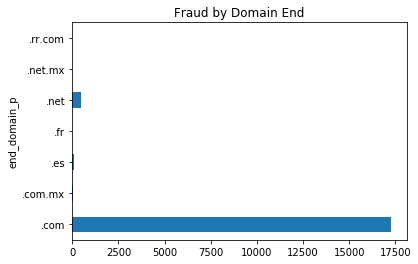

In [11]:
yes_fraud = train_transaction[train_transaction['isFraud']==1]
no_fraud = train_transaction[train_transaction['isFraud']==0]

yes_fraud.groupby('end_domain_p')['end_domain_p'].count().plot(kind='barh', x='end_domain_p', title = 'Fraud by Domain End')

# domain_count.plot(kind='bar', x='end_domain_p', y='isFraud')

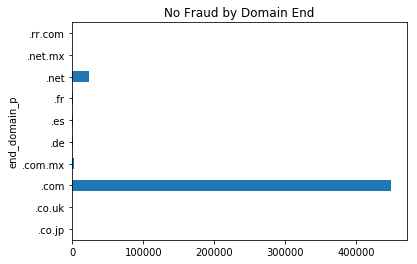

In [12]:
no_fraud.groupby('end_domain_p')['end_domain_p'].count().plot(kind='barh', x='end_domain_p', title = 'No Fraud by Domain End')

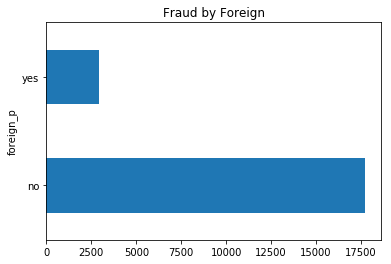

In [13]:
yes_fraud.groupby('foreign_p')['foreign_p'].count().plot(kind='barh', x='foreign_p', title = 'Fraud by Foreign')

### Transaction Time

In [248]:
train_transaction.tail()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,...,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
590535,3577535,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,56.0,56.0,56.0,T,T,T,M0,T,F,F,F,T,0.007391,-0.188248,-0.243307,-1.923534,-1.842798,...,-0.193181,-0.045679,-0.053971,-0.052641,-0.058704,-0.085924,-0.075689,-0.053423,-0.070627,-0.171201,0.198322,0.005701,-0.261633,-0.051078,-0.164933,-0.332327,1.892510,1.275010,-0.133973,-0.040597,-0.063553,-0.045782,-0.058540,-0.05521,-0.100748,-0.141694,-0.094118,-0.099555,-0.157153,-0.163368,-0.522447,-0.454035,-0.500168,-0.002603,-0.059497,-0.082134,-0.076247,-0.094586,-0.199006,-0.041047,-0.227586,0.277349,0.026672,0.180937,-0.048378,-0.062212,-0.05805,-0.055288,-0.088856,-0.074143
590536,3577536,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,T,F,F,M0,F,T,F,F,F,0.007391,-0.188248,-0.243307,0.348922,0.258476,...,-0.193181,-0.045679,-0.053971,-0.052641,-0.058704,-0.085924,-0.075689,-0.053423,-0.070627,-0.171201,0.198322,0.005701,-0.261633,-0.355728,-0.164933,-0.332327,-0.427737,-0.393796,-0.133973,-0.040597,-0.063553,-0.045782,-0.058540,-0.05521,-0.100748,-0.141694,-0.094118,-0.099555,-0.157153,-0.163368,-0.522447,-0.454035,-0.500168,-0.002603,-0.059497,-0.093052,-0.076247,-0.094586,-0.334848,-0.041047,-0.227586,-0.222636,-0.249507,-0.229407,-0.048378,-0.062212,-0.05805,-0.055288,-0.088856,-0.074143
590537,3577537,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,gmail.com,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,T,F,F,NaN,NaN,T,NaN,NaN,NaN,0.007391,-0.188248,-0.243307,0.348922,0.258476,...,-0.193181,-0.045679,-0.053971,-0.052641,-0.058704,-0.085924,-0.075689,-0.053423,-0.070627,-0.171201,0.198322,0.005701,-0.261633,-0.355728,-0.164933,-0.332327,-0.427737,-0.393796,-0.133973,-0.040597,-0.063553,-0.045782,-0.058540,-0.05521,-0.100748,-0.141694,-0.094118,-0.099555,-0.157153,-0.163368,-0.522447,-0.454035,-0.500168,-0.002603,-0.059497,-0.093052,-0.076247,-0.094586,-0.334848,-0.041047,-0.227586,-0.222636,-0.249507,-0.229407,-0.048378,-0.062212,-0.05805,-0.055288,-0.088856,-0.074143
590538,3577538,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,aol.com,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,22.0,22.0,22.0,T,T,T,M0,F,T,NaN,NaN,NaN,0.007391,-0.188248,-0.243307,2.621377,2.359750,...,0.532800,-0.045679,0.187975,-0.052641,-0.058704,-0.085924,-0.075689,-0.005854,-0.034722,-0.171201,1.283063,3.854989,2.693246,1.167524,-0.164933,0.594462,1.892510,1.275010,-0.133973,0.020931,-0.063553,-0.045782,0.219755,-0.05521,-0.100748,-0.141694,-0.094118,-0.099555,-0.157153,-0.163368,-0.522447,-0.454035,-0.500168,-0.002603,-0.009685,0.568038,-0.037530,0.911830,1.561845,-0.041047,0.452140,3.088004,3.606640,2.487679,-0.048378,0.499089,-0.05805,-0.055288,-0.088856,-0.074143
590539,3577539,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,credit,299.0,87.0,NaN,gmail.com,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,1.0,0.0,1.0,0.0,1.0,T,F,F,NaN,NaN,T,F,F,F,0.007391,-0.188248,-0.243307,0.348922,0.258476,...,-0.193181,-0.045679,-0.053971,-0.052641,0.894001,0.533698,0.727997,-0.005854,-0.034722,-0.171201,1.283063,0.647249,-0.261633,-0.355728,-0.164933,-0.332327,-0.427737,-0.393796,-0.133973,-0.040597,-0.063553,-0.045782,-0.058540,-0.05521,0.205555,1.449

In [15]:
train_transaction['Transaction_time_days'] = train_transaction['TransactionDT']/(86400)

train_transaction['Transaction_time_days'].describe()

count    590540.000000
mean         85.327677
std          53.440089
min           1.000000
25%          35.035391
50%          84.566291
75%         130.169213
max         182.999201
Name: Transaction_time_days, dtype: float64

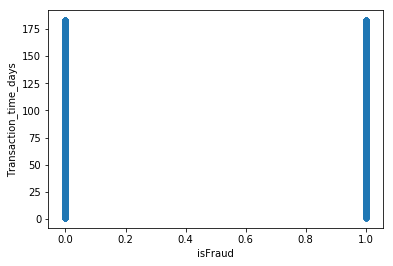

In [16]:
train_transaction.plot(kind='scatter', y='Transaction_time_days', x='isFraud')

### 'card1':'card6'

In [17]:
cards = [col for col in train_transaction.columns if 'card' in col]
train_transaction[cards].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


In [18]:
train_transaction = train_transaction.rename({'card4':'card_type','card6':'card_category'},axis=1)
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card_type,card5,card_category,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,domain_p,end_domain_p,foreign_p,domain_r,end_domain_r,foreign_r,Transaction_time_days
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,yes,1.000000
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gmail,.com,no,NaN,NaN,yes,1.000012
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,outlook,.com,no,NaN,NaN,yes,1.000799
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yahoo,.com,no,NaN,NaN,yes,1.001146
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gmail,.com,no,NaN,NaN,yes,1.001227


### 'D1':'D15'

In [19]:
d_cols = [c for c in train_transaction if c[0] == 'D']
train_transaction[d_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 'V1':'V339'

### PCA

In [5]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [ ]:
#sklearn class weight - will do much better in terms of ROC curve

In [101]:
v_cols = [col for col in train_transaction if col[0] == 'V']

In [171]:
v_d = pd.DataFrame(train_transaction[v_cols])
v_d.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,...,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,0.007391,-0.188248,-0.243307,0.348922,0.258476,-0.190849,-0.239092,-0.148892,-0.183482,-0.889542,-0.867054,0.862411,0.753187,0.022356,-0.368033,-0.360108,-0.36778,-0.364112,0.431549,0.331173,-0.382481,-0.368077,-0.140469,-0.19018,0.120595,0.057142,-0.027121,-0.02666,-0.759501,-0.733229,-0.395627,-0.386712,-0.383375,-0.389188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.193181,-0.045679,-0.023151,-0.052641,-0.058704,-0.085924,-0.075689,-0.053423,-0.070627,-0.171201,0.198322,0.005701,-0.261633,-0.355728,-0.164933,-0.332327,-0.427737,-0.393796,-0.133973,-0.040597,-0.063553,-0.045782,-0.033240,-0.055210,-0.100748,-0.141694,-0.094118,-0.099555,-0.157153,-0.163368,-0.522447,-0.454035,-0.500168,-0.002603,-0.059497,-0.066412,-0.076247,-0.094586,-0.334848,-0.041047,-0.227586,-0.222636,-0.249507,-0.229407,-0.048378,-0.032815,-0.058050,-0.055288,-0.088856,-0.074143
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.096328,-1.125861,0.022356,-0.368033,-0.360108,-0.36778,-0.364112,0.431549,0.331173,-0.382481,-0.368077,-0.140469,-0.19018,0.120595,0.057142,-0.027121,-0.02666,-0.759501,-0.733229,-0.395627,-0.386712,-0.383375,-0.389188,-1.051520,-1.074503,-0.156486,-0.189074,-0.367462,-0.350236,0.02704,-0.407731,-0.389843,-0.131255,-0.165502,-0.133672,-0.166114,-0.754,-0.732925,-0.440502,...,-0.193181,-0.045679,-0.053971,-0.052641,-0.058704,-0.085924,-0.075689,-0.053423,-0.070627,-0.171201,0.198322,0.005701,-0.261633,-0.355728,-0.164933,-0.332327,-0.427737,-0.393796,-0.133973,-0.040597,-0.063553,-0.045782,-0.058540,-0.055210,-0.100748,-0.141694,-0.094118,-0.099555,-0.157153,-0.163368,-0.522447,-0.454035,-0.500168,-0.002603,-0.059497,-0.093052,-0.076247,-0.094586,-0.334848,-0.041047,-0.227586,-0.222636,-0.249507,-0.229407,-0.048378,-0.062212,-0.058050,-0.055288,-0.088856,-0.074143
2,0.007391,-0.188248,-0.243307,0.348922,0.258476,-0.190849,-0.239092,-0.148892,-0.183482,-0.889542,-0.867054,0.862411,0.753187,0.022356,-0.368033,-0.360108,-0.36778,-0.364112,0.431549,0.331173,-0.382481,-0.368077,-0.140469,-0.19018,0.120595,0.057142,-0.027121,-0.02666,-0.759501,-0.733229,-0.395627,-0.386712,-0.383375,-0.389188,0.886429,0.780654,-0.156486,-0.189074,-0.367462,-0.350236,0.02704,-0.407731,-0.389843,-0.131255,-0.165502,-0.133672,-0.166114,-0.754,-0.732925,-0.440502,...,-0.193181,-0.045679,-0.053971,-0.052641,-0.058704,-0.085924,-0.075689,-0.053423,-0.070627,-0.171201,0.198322,0.005701,-0.261633,-0.355728,-0.164933,-0.332327,-0.427737,-0.393796,-0.133973,-0.040597,-0.063553,-0.045782,-0.058540,-0.055210,-0.100748,-0.141694,-0.094118,-0.099555,-0.157153,-0.163368,-0.522447,-0.454035,-0.500168,-0.002603,-0.059497,-0.093052,-0.076247,-0.094586,-0.334848,-0.041047,-0.227586,-0.222636,-0.249507,-0.229407,-0.048378,-0.062212,-0.058050,-0.055288,-0.088856,-0.074143
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.862411,0.753187,0.022356,-0.368033,-0.360108,-0.36778,-0.364112,0.431549,0.331173,-0.382481,-0.368077,-0.140469,-0.19018,0.120595,0.057142,-0.027121,-0.02666,-0.759501,-0.733229,-0.395627,-0.386712,-0.383375,-0.389188,0.886429,0.780654,-0.156486,-0.189074,-0.367462,-0.350236,0.02704,-0.407731,-0.389843,-0.131255,-0.165502,-0.133672,-0.166114,-0.754,-0.732925,-0.440502,...,0.644490,-0.023615,0.315862,0.232251,-0.058704,-0.085924,-0.075689,-0.005854,0.934696,-0.171201,-0.886418,-0.635848,-0.261633,2.690776,-0.164933,3.374829,-0.427737,-0.393796,-0.133973,-0.040597,-0.063553,0.002788,0.902842,0.869185,-0.100748,-0.141694,-0.094118,-0.099555,-0.157153,-0.163368,-0.522447,-0.454035,-0.500168,-0.002

In [250]:
train_transaction.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
P_emaildomain      94456
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D10                76022
D11               279287
D15                89113
M1                271100
M2                271100
M3                271100
M4                281444


In [8]:
train_transaction[v_cols].iloc[:,:20]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [46]:
train_transaction[v_cols].iloc[:,0].value_counts()

 0.007391      311236
-135.307058        17
Name: V1, dtype: int64

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_transaction[v_cols] = scaler.fit_transform(train_transaction[v_cols])

#### Examining distribution and correlation to impute before balancing

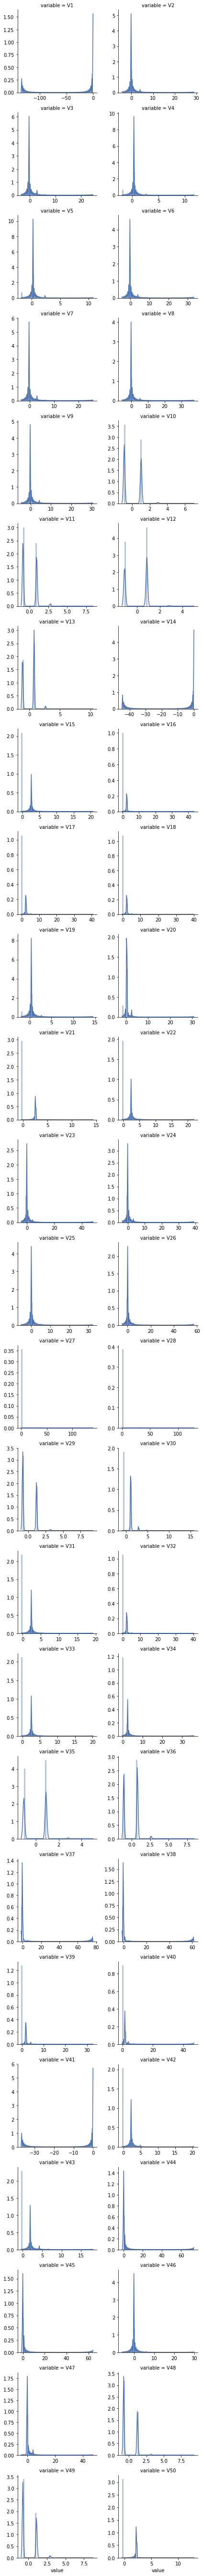

In [11]:
melted2 = pd.melt(train_transaction, value_vars=train_transaction[v_cols].iloc[:,:50])
sns.set_palette("deep")
melt2 = sns.FacetGrid(melted2, col="variable", palette='Set1', col_wrap=2, sharex=False, sharey=False)
melt2 = melt2.map(sns.distplot, "value")

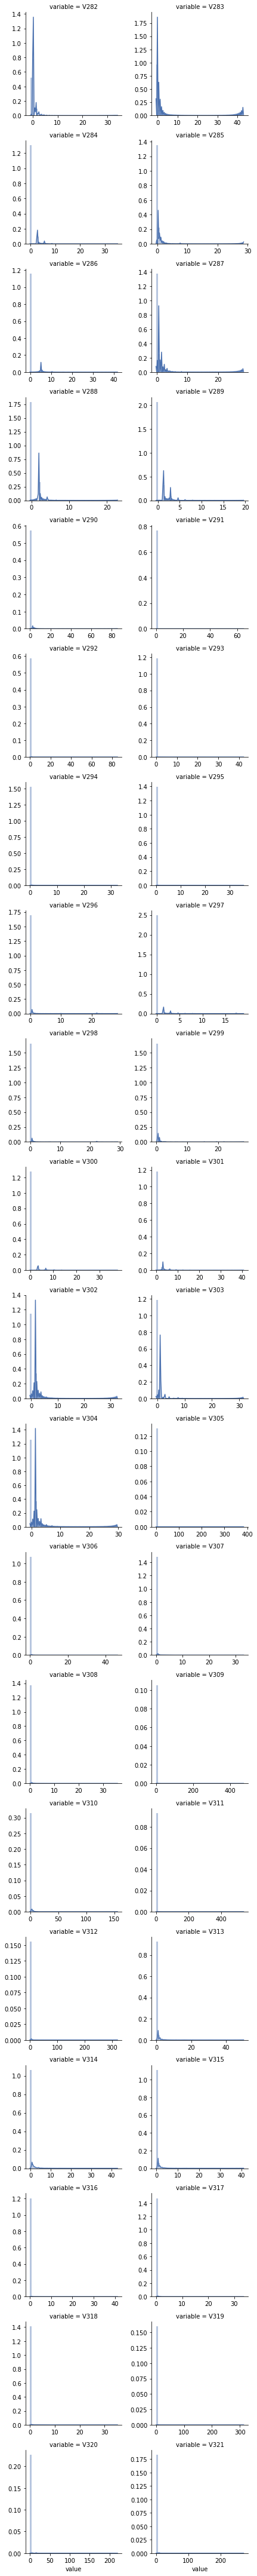

In [249]:
melted2 = pd.melt(train_transaction, value_vars=train_transaction[v_cols].iloc[:,140:])
sns.set_palette("deep")
melt2 = sns.FacetGrid(melted2, col="variable", palette='Set1', col_wrap=2, sharex=False, sharey=False)
melt2 = melt2.map(sns.distplot, "value")

In [92]:
corr = round(v_df[v_df.columns].corr(),2)
first_thirty = corr.head(20)

In [106]:
sample_v=train_transaction[v_cols].iloc[:,:80]

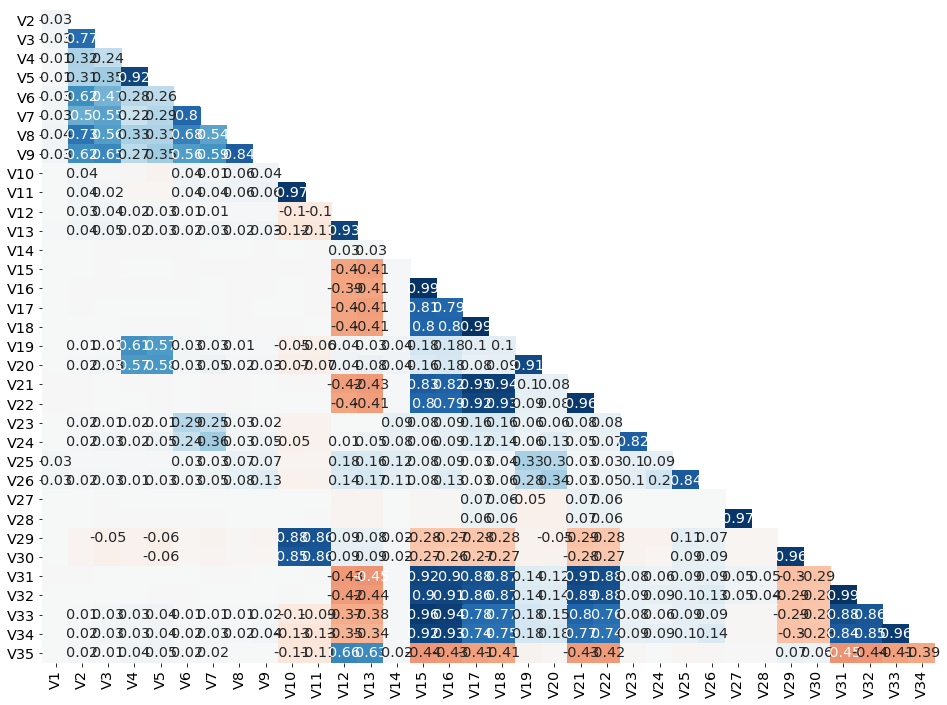

In [98]:
def plot_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    h_corr = sample_v.corr()
    
    # create a triangular mask to avoid repeated values and make
    # the plot easier to read
    h_corr = h_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(h_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(16,12))
    ax = sns.heatmap(h_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()

plot_correlations(sample_v)

In [ ]:
##dummify the missing in new column.

#train a model to predict the missing values

#### Imputing using a weighted average

In [143]:
hek = np.array([1,1,1,1,1,2,2,2,2,2,3,3,4,5,6])
hekk = train_transaction['V1'].value_counts()/train_transaction['V1'].notnull().sum()
hekk = pd.DataFrame(hekk)
hekk
# train_transaction['V1'].value_counts()

,V1
0.007391,0.999945
-135.307058,0.000055


In [150]:
def weighted_avg(df):
    for col in df:
        pct_value = df[col].value_counts()/df[col].notnull().sum()
        pct_value = pd.DataFrame(pct_value)
        weights = []
        for i in df[col]:
            if df[col].mode()==i:
                weights.append(0.70)
            elif pct_value[i]>.40:
                weights.append(.25)
            else:
                weight.append(.5)
            return np.array(weights)

In [151]:
for col in v_df:
    v_df[col].apply(weighted_avg)

TypeError: 'float' object is not iterable

### Impute with scikitlearn imputer

In [153]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [154]:
imp = IterativeImputer(n_nearest_features=25, initial_strategy='most_frequent', imputation_order='random')

In [155]:
imp.fit(v_df)

IterativeImputer(add_indicator=False, estimator=None, imputation_order='random',
                 initial_strategy='most_frequent', max_iter=10, max_value=None,
                 min_value=None, missing_values=nan, n_nearest_features=25,
                 random_state=None, sample_posterior=False, tol=0.001,
                 verbose=0)

In [158]:
imp = IterativeImputer(add_indicator=False, estimator=None, imputation_order='random',
                 initial_strategy='most_frequent', max_iter=10, max_value=None,
                 min_value=None, n_nearest_features=12,
                 random_state=None, sample_posterior=False, tol=0.001,
                 verbose=0)

In [160]:
imp.fit(v_df)
v_df = np.round(imp.transform(v_df))

In [196]:
v_df.shape

(590540, 180)

In [219]:
v_d.describe(include='all')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,...,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,...,5.902260e+05,5.902260e+05,5.902260e+05,5.902260e+05,5.902260e+05,5.902260e+05,5.902260e+05,5.905280e+05,5.905280e+05,5.892710e+05,5.892710e+05,5.892710e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.892710e+05,5.892710e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.892710e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.892710e+05,5.892710e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.892710e+05,5.892710e+05,5.892710e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05
mean,-8.676441e-15,-2.051515e-13,1.443259e-13,-1.859458e-14,-3.547424e-14,1.490332e-13,-4.370567e-14,-2.210856e-14,1.201598e-13,-7.516310e-15,3.127907e-14,-1.722505e-13,-3.286584e-13,-2.269583e-14,-1.161087e-13,1.139471e-13,5.169779e-15,-1.299679e-14,2.421688e-14,4.444041e-14,1.224033e-14,2.353615e-14,1.716659e-14,-5.290181e-15,-1.250699e-13,6.333180e-16,1.617222e-14,-3.795915e-14,1.078530e-14,7.458770e-14,1.571956e-13,-1.666889e-13,-8.166945e-14,-4.604323e-14,-6.789538e-13,3.157022e-13,2.807201e-14,3.705801e-14,-1.322320e-13,2.056814e-13,-1.610720e-14,-2.075853e-13,-1.686264e-13,-2.536077e-14,1.625796e-15,4.068445e-14,3.119645e-14,-1.802894e-13,-1.873524e-14,2.447976e-13,...,-1.666677e-13,1.652238e-13,-1.276971e-13,-1.114686e-13,1.157100e-13,-4.570759e-14,-4.215904e-13,-2.499663e-13,-6.167201e-14,3.387865e-14,2.850032e-13,-1.790919e-14,1.213285e-13,4.777490e-14,-1.524860e-14,2.490772e-13,-1.285762e-13,2.191303e-13,4.406381e-14,7.933534e-15,-9.891996e-15,2.802114e-13,-1.203247e-13,-3.041641e-13,3.652604e-13,3.463652e-14,-2.290180e-13,3.889267e-13,-1.564645e-14,1.850269e-14,-4.095120e-13,4.099336e-13,3.088466e-13,-3.651035e-14,2.911534e-14,-5.270888e-14,-8.466125e-14,-2.326013e-14,-2.543672e-13,-2.185787e-15,-1.521136e-13,-1.134117e-13,-1.068936e-13,-1.298894e-13,6.727267e-14,8.070332e-14,-3.399136e-13,1.320452e-13,-2.044231e-13,-2.267562e-13
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1

In [220]:
v_fin = pd.DataFrame(v_df)
v_fin.describe(include='all')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.00000,590540.000000,590540.000000,590540.000000,590540.000000,...,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,-0.212199,1.173209,0.829212,-1.453366,-1.722332,0.593821,0.403722,1.596683,1.956462,-0.980613,-0.991935,0.091604,0.160253,-0.032530,0.329095,0.330057,0.263166,0.271502,-0.312522,-0.242815,0.362837,0.268774,0.138202,0.165889,-0.100290,-0.058237,0.030284,0.029868,-0.323844,-0.292226,0.267433,0.270539,0.349097,0.248175,0.072352,0.129097,0.099111,0.120104,0.378156,0.285280,-0.028156,0.263117,0.279608,0.077995,0.105085,0.06216,0.094656,-0.307163,-0.282020,0.264082,...,0.155991,0.040864,0.047206,0.046800,0.052782,0.074842,0.067726,0.039652,0.049130,0.174376,-0.173536,-0.108656,0.265548,0.218583,0.157751,0.327458,0.369387,0.293768,0.113249,0.021628,0.032198,0.039051,0.049888,0.047052,0.089494,0.119873,0.081920,0.075795,0.145330,0.156386,-0.258807,0.316947,-0.471595,0.002601,0.046942,0.062074,0.056198,0.082199,0.214079,0.038558,0.166422,0.171582,0.191757,0.186751,0.042307,0.053370,0.050398,0.048789,0.077304,0.065003
std,3.373265,2.743438,2.439828,4.820239,6.021541,1.723549,1.614319,3.514470,4.361682,2.392657,2.463972,0.961889,1.003816,1.178895,0.947270,0.966351,0.754144,0.776050,0.849385,0.958939,0.974882,0.757074,0.973432,0.916053,0.909574,0.980748,1.024545,1.026037,0.988129,1.064249,0.712804,0.746759,0.966311,0.710449,0.953555,0.982996,0.842321,0.837008,0.847657,0.898363,0.997416,0.737279,0.802327,0.838959,0.849104,0.89243,0.819992,0.994878,1.049345,0.698909,...,0.977257,0.997780,0.997660,0.998297,0.997368,0.995132,0.993459,0.997824,0.997223,1.008566,0.978934,1.113221,1.013190,0.949288,0.959968,0.948822,0.872720,0.858317,0.968279,0.999152,0.995270,0.998030,0.997226,0.998111,1.007246,0.952589,0.988028,0.998762,0.960723,0.965536,1.370691,0.836544,1.055597,0.999391,0.997729,0.996309,0.996894,0.996165,0.947224,0.998622,0.965869,0.965535,0.959736,0.969768,0.997952,0.997591,0.997213,0.995723,0.992747,0.989080
min,-135.000000,-16.000000,-49.000000,-242.000000,-303.000000,-37.000000,-26.000000,-9.000000,-38.000000,-29.000000,-30.000000,-2.000000,-2.000000,-49.000000,-1.000000,-1.000000,-1.000000,-1.000000,-4.000000,-2.000000,-1.000000,-1.000000,-4.000000,-3.000000,-5.000000,-5.000000,-10.000000,-12.000000,-1.000000,-1.000000,-2.000000,-1.000000,-2.000000,-3.000000,-4.000000,-5.000000,-3.000000,-4.000000,-2.000000,-2

In [225]:
v_fin = scaler.fit_transform(v_fin)
col_names = list(v_d.columns)
v_fin = pd.DataFrame(v_fin, columns = col_names)

In [226]:
v_fin.describe(include='all')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,...,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,...,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05
mean,-5.260789e-14,3.166960e-14,7.688014e-14,-2.031379e-13,2.830029e-13,3.629616e-14,1.770912e-13,-1.830172e-13,-7.194888e-14,-3.887018e-14,-4.995918e-14,2.370747e-14,9.325908e-13,-1.974906e-14,2.301023e-15,6.098526e-14,2.211804e-14,-6.533386e-14,1.676291e-13,5.618689e-14,3.416547e-14,-8.562058e-15,6.264343e-15,3.827407e-14,1.481596e-13,5.953944e-14,1.914886e-14,1.404014e-14,2.512178e-13,-1.412659e-14,4.332908e-14,-1.381375e-13,-4.015701e-14,-1.320214e-15,4.829170e-13,2.758579e-14,-3.224119e-14,-3.547406e-14,-3.057036e-13,8.049110e-14,2.448961e-14,5.299261e-14,6.851866e-14,5.795918e-14,7.312252e-14,-5.917806e-14,1.954387e-15,-2.556285e-13,2.275910e-13,-4.833204e-14,...,-9.067012e-14,4.270067e-13,3.719981e-13,-3.108565e-13,1.233222e-13,2.319554e-13,-2.758504e-13,3.950354e-13,4.081067e-13,2.080132e-14,-1.137010e-13,-2.793508e-15,1.413417e-13,8.685885e-15,7.050044e-15,-1.171937e-13,-1.965449e-13,9.225213e-14,2.554868e-14,-1.133098e-14,5.229529e-15,1.058441e-13,2.533537e-13,-2.035233e-13,4.487546e-13,9.139876e-14,-1.712430e-13,-2.584331e-13,9.116383e-15,-5.298998e-16,4.357978e-13,-2.284267e-13,8.710422e-14,9.273577e-15,-3.332915e-13,4.453870e-13,3.134542e-13,-1.926762e-15,-4.607635e-13,9.578668e-16,-2.545780e-13,1.687573e-13,-1.517727e-13,-1.803993e-13,1.613536e-13,7.224803e-14,-1.193698e-13,-1.884390e-14,-1.179255e-13,1.562489e-13
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.

In [224]:
v_d.describe(include='all')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,...,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,3.112530e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,5.144670e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,4.215710e+05,...,5.902260e+05,5.902260e+05,5.902260e+05,5.902260e+05,5.902260e+05,5.902260e+05,5.902260e+05,5.905280e+05,5.905280e+05,5.892710e+05,5.892710e+05,5.892710e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.892710e+05,5.892710e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.892710e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.892710e+05,5.892710e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.892710e+05,5.892710e+05,5.892710e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05,5.905280e+05
mean,-8.676441e-15,-2.051515e-13,1.443259e-13,-1.859458e-14,-3.547424e-14,1.490332e-13,-4.370567e-14,-2.210856e-14,1.201598e-13,-7.516310e-15,3.127907e-14,-1.722505e-13,-3.286584e-13,-2.269583e-14,-1.161087e-13,1.139471e-13,5.169779e-15,-1.299679e-14,2.421688e-14,4.444041e-14,1.224033e-14,2.353615e-14,1.716659e-14,-5.290181e-15,-1.250699e-13,6.333180e-16,1.617222e-14,-3.795915e-14,1.078530e-14,7.458770e-14,1.571956e-13,-1.666889e-13,-8.166945e-14,-4.604323e-14,-6.789538e-13,3.157022e-13,2.807201e-14,3.705801e-14,-1.322320e-13,2.056814e-13,-1.610720e-14,-2.075853e-13,-1.686264e-13,-2.536077e-14,1.625796e-15,4.068445e-14,3.119645e-14,-1.802894e-13,-1.873524e-14,2.447976e-13,...,-1.666677e-13,1.652238e-13,-1.276971e-13,-1.114686e-13,1.157100e-13,-4.570759e-14,-4.215904e-13,-2.499663e-13,-6.167201e-14,3.387865e-14,2.850032e-13,-1.790919e-14,1.213285e-13,4.777490e-14,-1.524860e-14,2.490772e-13,-1.285762e-13,2.191303e-13,4.406381e-14,7.933534e-15,-9.891996e-15,2.802114e-13,-1.203247e-13,-3.041641e-13,3.652604e-13,3.463652e-14,-2.290180e-13,3.889267e-13,-1.564645e-14,1.850269e-14,-4.095120e-13,4.099336e-13,3.088466e-13,-3.651035e-14,2.911534e-14,-5.270888e-14,-8.466125e-14,-2.326013e-14,-2.543672e-13,-2.185787e-15,-1.521136e-13,-1.134117e-13,-1.068936e-13,-1.298894e-13,6.727267e-14,8.070332e-14,-3.399136e-13,1.320452e-13,-2.044231e-13,-2.267562e-13
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1

In [229]:
for col in v_fin:
    for col in v_d:
        print(v_fin[col].mean() - v_d[col].mean())

-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.33199588

-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178

-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704

-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.27175596131

-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.80566452432

-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978

-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13
7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13
7.612254129819611e-15
2.776629505584286e-13
1.4573991482543174e-13
6.450016283084273e-13
4.697787458737076e-13
-1

-3.908901803498548e-14
2.2298640069407907e-14
-3.6627092719231483e-13
-6.79687794813877e-14
-1.2687817378166142e-13
-1.85151328210983e-14
-1.926451662996444e-14
1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-1.903258564984563e-14
8.453097715130612e-13
-6.38360299743572e-13
-2.2174234694361223e-13
4.578392675132039e-14
-3.624068372683336e-13
4.980958978599591e-13
3.98115480900503e-13
2.1333364503588382e-14
-2.063963558335792e-13
3.1436538635510643e-15
-1.0246434022374683e-13
2.8216895181109726e-13
-4.4879040715016724e-14
-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-1

2.8216895181109726e-13
-4.4879040715016724e-14
-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677

-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.80566452432

9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13
7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13


-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.33199588

-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.17688620136838

-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13
7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13
7.612254129819611e-15
2.776629505584286e-13
1.4573991482543174e-13
6.450016283084273e-13
4.697787458737076e-13
-1.3077328003940156e-14
-3.987041795183612e-13
1.511568299908642e-14
2.0013117619098084e-14
-3.908901803498548e-14
2.2298640069407907e-14
-3.6627092719231483e-13
-6.79687794813877e-14
-1.2687817378166142e-13
-1.85151328210983e-14
-1.926451662996444e-14
1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-1.903258564984563e-14
8.453097715130612e-13


-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585

2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766

2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877

-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.17688620136838

4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-

4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13
7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13
7.612254129819611e-15
2.776629505584286e-13
1.4573991482543174e-13
6.450016283084273e-13
4.697787458737076e-13
-1.3077328003940156e-14
-3.987041795183612e-13
1.511568299908642e-14
2.0013117619098084e-14
-3.908901803498548e-14
2.2298640069407907e-14
-3.6627092719231483e-13
-6.79687794813877e-14
-1.2687817378166142e-13
-1.85151328210983e-14
-1.926451662996444e-14
1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-1.903258564984563e-14
8

-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964

-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868

-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-1

1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-1.903258564984563e-14
8.453097715130612e-13
-6.38360299743572e-13
-2.2174234694361223e-13
4.578392675132039e-14
-3.624068372683336e-13
4.980958978599591e-13
3.98115480900503e-13
2.1333364503588382e-14
-2.063963558335792e-13
3.1436538635510643e-15
-1.0246434022374683e-13
2.8216895181109726e-13
-4.4879040715016724e-14
-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-

5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835

2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.

4.697787458737076e-13
-1.3077328003940156e-14
-3.987041795183612e-13
1.511568299908642e-14
2.0013117619098084e-14
-3.908901803498548e-14
2.2298640069407907e-14
-3.6627092719231483e-13
-6.79687794813877e-14
-1.2687817378166142e-13
-1.85151328210983e-14
-1.926451662996444e-14
1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-1.903258564984563e-14
8.453097715130612e-13
-6.38360299743572e-13
-2.2174234694361223e-13
4.578392675132039e-14
-3.624068372683336e-13
4.980958978599591e-13
3.98115480900503e-13
2.1333364503588382e-14
-2.063963558335792e-13
3.1436538635510643e-15
-1.0246434022374683e-13
2.8216895181109726e-13
-4.4879040715016724e-14
-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13


1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.12361872

2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0

7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13
7.612254129819611e-15
2.776629505584286e-13
1.4573991482543174e-13
6.450016283084273e-13
4.697787458737076e-13
-1.3077328003940156e-14
-3.987041795183612e-13
1.511568299908642e-14
2.0013117619098084e-14
-3.908901803498548e-14
2.2298640069407907e-14
-3.6627092719231483e-13
-6.79687794813877e-14
-1.2687817378166142e-13
-1.85151328210983e-14
-1.926451662996444e-14
1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-1.903258564984563e-14
8.453097715130612e-13
-6.38360299743572e-13
-2.2174234694361223e-13
4.578392675132039e-14
-3.624068372683336e-13
4.980958978599591e-13
3.98115480900503e-13
2.1333364503588382e-14
-2.063963558335792e-13
3.1436538635510643e-15
-1.0246434022374683e-13
2.8216895181109726e-13
-4.4879040715016724e-14
-5.050996400005792e-14
9

-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.46326241321

2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.039709983225908

-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13
7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13
7.612254129819611e-15
2.776629505584286e-13
1.4573991482543174e-13
6.450016283084273e-13
4.697787458737076e-13
-1.3077328003940156e-14
-3.987041795183612e-13
1.511568299908642e-14
2.

3.1436538635510643e-15
-1.0246434022374683e-13
2.8216895181109726e-13
-4.4879040715016724e-14
-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.151243723326

-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.80566452432

-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13


1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-1.903258564984563e-14
8.453097715130612e-13
-6.38360299743572e-13
-2.2174234694361223e-13
4.578392675132039e-14
-3.624068372683336e-13
4.980958978599591e-13
3.98115480900503e-13
2.1333364503588382e-14
-2.063963558335792e-13
3.1436538635510643e-15
-1.0246434022374683e-13
2.8216895181109726e-13
-4.4879040715016724e-14
-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-

5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.41350507

3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1

2.0013117619098084e-14
-3.908901803498548e-14
2.2298640069407907e-14
-3.6627092719231483e-13
-6.79687794813877e-14
-1.2687817378166142e-13
-1.85151328210983e-14
-1.926451662996444e-14
1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-1.903258564984563e-14
8.453097715130612e-13
-6.38360299743572e-13
-2.2174234694361223e-13
4.578392675132039e-14
-3.624068372683336e-13
4.980958978599591e-13
3.98115480900503e-13
2.1333364503588382e-14
-2.063963558335792e-13
3.1436538635510643e-15
-1.0246434022374683e-13
2.8216895181109726e-13
-4.4879040715016724e-14
-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-

-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148

-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238

7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13
7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13
7.612254129819611e-15
2.776629505584286e-13
1.4573991482543174e-13
6.450016283084273e-13
4.697787458737076e-13
-1.3077328003940156e-14
-3

4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13
7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13
7.612254129819611e-15
2.776629505584286e-13
1.4573991482543174e-13
6.450016283084273e-13
4.697787458737076e-13
-1.3077328003940156e-14
-3.987041795183612e-13
1.511568299908642e-14
2.0013117619098084e-14
-3.908901803498548e-14
2.2298640069407907e-14
-3.6627092719231483e-13
-6.79687794813877e-14
-1.2687817378166142e-13
-1.85151328210983e-14
-1.926451662996444e-14
1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-1.903258564984563e-14
8.453097715130612e-13
-6.38360299743572e-13
-2.2174234694361223e-13
4.578392675132039e-14
-3.624068372683336e-13
4.9

-4.4879040715016724e-14
-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.881163880477

-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338

2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0

-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13
7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13
7.612254129819611e-15
2.776629505584286e-13
1.4573991482543174e-13
6.450016283084273e-13
4.697787458737076e-13
-1.3077328003940156e-14
-3.987041795183612e-13
1.511568299908642e-14
2.0013117619098084e-14
-3.908901803498548e-14
2.2298640069407907e-14
-3.6627092719231483e-13
-6.79687794813877e-14
-1.2687817378166142e-13
-1.85151328210983e-14
-1.926451662996444e-14
1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-1.903258564984563e-14
8.453097715130612e-13
-6.38360299743572e-13
-2.2174234694361223e-13
4.578392675132039e-14
-3

-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178

7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.05760886113197

-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-1

-1.2687817378166142e-13
-1.85151328210983e-14
-1.926451662996444e-14
1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-1.903258564984563e-14
8.453097715130612e-13
-6.38360299743572e-13
-2.2174234694361223e-13
4.578392675132039e-14
-3.624068372683336e-13
4.980958978599591e-13
3.98115480900503e-13
2.1333364503588382e-14
-2.063963558335792e-13
3.1436538635510643e-15
-1.0246434022374683e-13
2.8216895181109726e-13
-4.4879040715016724e-14
-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e

1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.27827555261

-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255

3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13
7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13
7.612254129819611e-15
2.776629505584286e-13
1.4573991482543174e-13
6.450016283084273e-13
4.

-3.624068372683336e-13
4.980958978599591e-13
3.98115480900503e-13
2.1333364503588382e-14
-2.063963558335792e-13
3.1436538635510643e-15
-1.0246434022374683e-13
2.8216895181109726e-13
-4.4879040715016724e-14
-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.19992904874398

4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671

4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.

1.4573991482543174e-13
6.450016283084273e-13
4.697787458737076e-13
-1.3077328003940156e-14
-3.987041795183612e-13
1.511568299908642e-14
2.0013117619098084e-14
-3.908901803498548e-14
2.2298640069407907e-14
-3.6627092719231483e-13
-6.79687794813877e-14
-1.2687817378166142e-13
-1.85151328210983e-14
-1.926451662996444e-14
1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-1.903258564984563e-14
8.453097715130612e-13
-6.38360299743572e-13
-2.2174234694361223e-13
4.578392675132039e-14
-3.624068372683336e-13
4.980958978599591e-13
3.98115480900503e-13
2.1333364503588382e-14
-2.063963558335792e-13
3.1436538635510643e-15
-1.0246434022374683e-13
2.8216895181109726e-13
-4.4879040715016724e-14
-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-

2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093

1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14


1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13
7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13
7.612254129819611e-15
2.776629505584286e-13
1.4573991482543174e-13
6.450016283084273e-13
4.697787458737076e-13
-1.3077328003940156e-14
-3.987041795183612e-13
1.511568299908642e-14
2.0013117619098084e-14
-3.908901803498548e-14
2.2298640069407907e-14
-3.6627092719231483e-13
-6.79687794813877e-14
-1.2687817378166142e-13
-1.85151328210983e-14
-1.926451662996444e-14
1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-

-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.33199588

4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e

-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13

1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-1.903258564984563e-14
8.453097715130612e-13
-6.38360299743572e-13
-2.2174234694361223e-13
4.578392675132039e-14
-3.624068372683336e-13
4.980958978599591e-13
3.98115480900503e-13
2.1333364503588382e-14
-2.063963558335792e-13
3.1436538635510643e-15
-1.0246434022374683e-13
2.8216895181109726e-13
-4.4879040715016724e-14
-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-

4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.52517780118

2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.

6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13
7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13
7.612254129819611e-15
2.776629505584286e-13
1.4573991482543174e-13
6.450016283084273e-13
4.697787458737076e-13
-1.3077328003940156e-14
-3.987041795183612e-13
1.511568299908642e-14
2.0013117619098084e-14
-3.908901803498548e-14
2.2298640069407907e-14
-3.6627092719231483e-13
-6.79687794813877e-14
-1.2687817378166142e-13
-1.85151328210983e-14
-1.926451662996444e-14
1.5121525437677883e-14
-1.7436732875883796e-13
3.73678337783264e-13
1.0064078958301293e-13
8.349420582097012e-14
5.676223993827081e-14
5.777493430754529e-14
-6.473597854486778e-13
2.4762836873454878e-14
-1.903258564984563e-14
8.453097715130612e-13
-6.38360299743572e-13
-2.2174234694361223e-13
4.578392675132039e-14
-3.624068372683336e-13
4.980958978599591e-13
3.98115480900503e-13
2.133

3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.5339051602

2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.039709983225908

-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13
7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13
7.612254129819611e-15
2.776629505584286e-13
1.4573991482543174e-13
6.450016283084273e-13
4.697787458737076e-13
-1.3077328003940156e-14
-3.987041795183612e-13
1

4.578392675132039e-14
-3.624068372683336e-13
4.980958978599591e-13
3.98115480900503e-13
2.1333364503588382e-14
-2.063963558335792e-13
3.1436538635510643e-15
-1.0246434022374683e-13
2.8216895181109726e-13
-4.4879040715016724e-14
-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.97663559746654

4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401

2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.

-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13
7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13
7.612254129819611e-15
2.776629505584286e-13
1.4573991482543174e-13
6.450016283084273e-13
4.697787458737076e-13
-1.3077328003940156e-14
-3.987041795183612e-13
1.511568299908642e-14
2.0013117619098084e-14
-3.908901803498548e-14
2.2298640069407907e-14
-3.6627092719231483e-13
-6.79687794813877e-14
-1.2687817378166142e-13
-1.85151328210983e-14
-1.926451662996444e-14
1.5121525437677883e-

4.980958978599591e-13
3.98115480900503e-13
2.1333364503588382e-14
-2.063963558335792e-13
3.1436538635510643e-15
-1.0246434022374683e-13
2.8216895181109726e-13
-4.4879040715016724e-14
-5.050996400005792e-14
9.408096585160729e-14
-8.455288079287108e-15
2.205438265209919e-13
-1.50889131230782e-13
8.649760977165375e-14
3.8300516678796327e-13
-4.3931445504332074e-14
2.368210511893414e-13
-6.744571931456702e-14
-1.8454334126570773e-13
3.1847713207744903e-13
-1.1273706734343231e-13
2.207968401341602e-13
-1.6090863343904545e-13
-1.921087076821953e-13
-3.1353869304134415e-14
-8.123824627230331e-14
1.9595795663712374e-13
1.2612492721485433e-12
2.946764366522398e-15
1.1840971049052112e-13
-5.296181854272204e-14
1.6948264069317545e-14
-5.2337068662419407e-14
1.4341223841728104e-13
1.1746482651278076e-14
2.1925145714882985e-14
-3.209820958220724e-14
-1.0902246236349845e-14
4.356425443501133e-14
2.7322949017218884e-13
5.89061181126136e-14
2.976635597466548e-15
5.1999290487439824e-14
2.40432515048939

5.1999290487439824e-14
2.404325150489397e-13
-8.871428868784636e-14
-1.1386652153768273e-13
2.855141173701411e-14
4.1512437233262283e-14
4.4723019338052555e-14
1.1618708545677554e-12
-2.8811638804779377e-13
-6.031319840964841e-14
-7.253207878488758e-14
-1.7347163669875623e-13
-1.2519028766328922e-13
4.059681585395927e-14
2.6057792712736384e-13
2.3714509573813885e-13
8.331995880257082e-14
7.14967249744579e-14
-9.986250952492928e-14
-2.9242068178569335e-14
-7.533905160281119e-14
2.463262413215002e-13
-2.9312966369668507e-13
-1.0326061704809455e-13
1.2717559613185203e-14
-9.458869647959892e-13
-2.728164624822949e-14
1.1482101212698959e-14
-2.2782755526115157e-13
-2.0824472093261003e-13
-2.1236187239333284e-13
1.3720048470633336e-13
6.787893122002753e-14
1.4462806937478764e-13
-1.4091716658623262e-13
-8.361304383084298e-14
2.955822877034217e-13
2.3203306148926213e-14
2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.41350507

2.3371003338891755e-13
2.5251778011851164e-13
1.7542227788754264e-14
2.2855583835082353e-13
1.951259434161659e-13
3.4135050795290886e-13
2.0856165445015813e-14
2.015166892684148e-14
4.907151509557017e-14
-1.327137771461186e-13
3.591273401191717e-13
3.0745308671527773e-14
8.149993019771304e-14
-1.3263948189507136e-14
1.8056645243233055e-13
2.166929597276491e-13
-8.28890848868111e-14
6.51342187277379e-14
-2.807450993012062e-13
4.5461864254793296e-14
-3.3281969544499366e-14
-3.04240472187632e-14
-3.0576088611319786e-14
3.929153453255822e-14
-7.939440093978052e-14
9.042471324072316e-14
2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.

2.0397099832259087e-13
2.1768862013683844e-13
4.4410807115260237e-14
3.386551070339878e-13
-1.2952127020343238e-13
7.177878644419716e-13
-1.212886800328567e-13
-5.396388953259894e-13
-5.805457008995219e-14
4.1716561933681217e-13
6.627185204011903e-13
1.0131715864027171e-13
-9.02176914986717e-14
7.080843430304945e-13
-5.53982169039882e-13
3.074273425407298e-14
-3.074845135068914e-15
1.0580640072232562e-13
-1.9544174218095346e-14
-1.5891339326850904e-14
-9.100491652054543e-14
2.4654420804582695e-15
6.28549695213164e-14
-5.089397704683111e-13
1.1165074399402405e-14
4.32654507862369e-14
-1.125740203264482e-13
-1.1868060522545247e-14
1.1453688379374689e-14
-1.1324024996085028e-13
4.622472035137545e-14
-7.778529313185318e-14
6.953687794086166e-13
1.0078612582342945e-13
4.735444446163681e-13
-3.190198947863902e-13
-1.1963384742237538e-14
3.124383275005212e-14
-3.428367172165052e-13
7.599759192520074e-14
2.617828989072858e-13
4.996951787430977e-13
-1.9938790038022063e-13
7.612254129819611e-15


#### Balancing data using SMOTE

In [230]:
sm = SMOTE(ratio='minority', k_neighbors=13)
v_fin, y_train = sm.fit_sample(v_fin, y_train)

In [232]:
v_fin = pd.DataFrame(v_fin, columns = col_names)
v_fin.describe(include='all')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,...,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,...,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06,1.139754e+06
mean,-5.506835e-03,4.118793e-01,3.282859e-01,-2.093763e-01,-2.074908e-01,4.036882e-01,4.605191e-01,4.257001e-01,4.225391e-01,-3.781199e-01,-4.005540e-01,-1.260583e-01,-1.171043e-01,5.138096e-03,3.990956e-01,3.901473e-01,4.108874e-01,4.124849e-01,8.159783e-02,9.085484e-02,3.813189e-01,3.466029e-01,3.344087e-01,2.797778e-01,4.400846e-03,2.218894e-02,-1.070214e-02,-1.047630e-02,-2.607290e-01,-2.517687e-01,3.544921e-01,3.413582e-01,4.079687e-01,3.874774e-01,-1.483043e-01,-1.400764e-01,3.540232e-01,3.888029e-01,4.198428e-01,4.315900e-01,2.952961e-03,3.842241e-01,4.041153e-01,5.298691e-01,5.590257e-01,2.376091e-01,3.123837e-01,-2.635436e-01,-2.562834e-01,3.550495e-01,...,5.480202e-02,-1.686268e-02,-1.455451e-02,-1.570358e-02,-4.438354e-03,-5.465576e-03,-4.837031e-03,-1.724296e-02,-1.321955e-02,1.646865e-01,2.386030e-01,2.706587e-01,7.295670e-02,-2.128975e-02,2.332008e-03,3.722911e-02,7.586218e-02,9.461595e-02,7.886336e-02,4.762184e-02,5.181581e-02,-1.703590e-02,2.968205e-03,-1.329453e-02,5.154002e-03,-2.853075e-03,-1.111834e-03,-9.568858e-03,4.881984e-02,6.371358e-02,3.412181e-01,2.665130e-01,3.252269e-01,-1.254115e-03,-1.365641e-02,7.045881e-03,-3.537763e-03,4.248424e-02,2.509563e-02,2.293648e-04,7.890686e-02,9.425806e-02,8.023274e-02,1.084841e-01,-1.379924e-02,4.082387e-03,-5.940715e-03,-2.753673e-03,7.592484e-03,-1.500962e-03
std,9.470709e-01,1.552821e+00,1.670050e+00,1.859519e+00,1.864314e+00,1.728352e+00,1.968068e+00,1.412456e+00,1.428758e+00,1.274913e+00,1.290764e+00,1.015623e+00,1.047087e+00,8.678816e-01,1.361148e+00,1.348712e+00,1.656189e+00,1.639832e+00,9.890150e-01,1.044111e+00,1.316273e+00,1.259546e+00,2.306701e+00,2.044926e+00,1.092310e+00,1.110383e+00,7.232733e-01,7.232531e-01,8.590691e-01,8.553911e-01,1.281451e+00,1.270342e+00,1.350575e+00,1.333652e+00,9.836169e-01,1.007836e+00,2.725802e+00,2.656196e+00,1.587982e+00,1.674009e+00,8.890891e-01,1.393636e+00,1.490827e+00,3.325349e+00,3.142371e+00,1.869137e+00,2.163291e+00,8.624712e-01,8.652510e-01,1.270318e+00,...,1.042349e+00,7.217700e-01,7.266885e-01,7.252954e-01,7.571971e-01,7.796188e-01,7.726408e-01,7.214890e-01,7.521389e-01,1.461020e+00,1.229027e+00,1.390188e+00,1.088703e+00,8.272026e-01,9.763551e-01,9.240605e-01,1.080982e+00,1.175058e+00,1.45920

In [234]:
v_fin.shape

(1139754, 180)

#### Scaling before we PCA

In [235]:
scaled_v = preprocessing.scale(v_fin.T)

In [236]:
pca = PCA()
pca.fit(scaled_v)
pca_v = pca.transform(scaled_v)

In [237]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

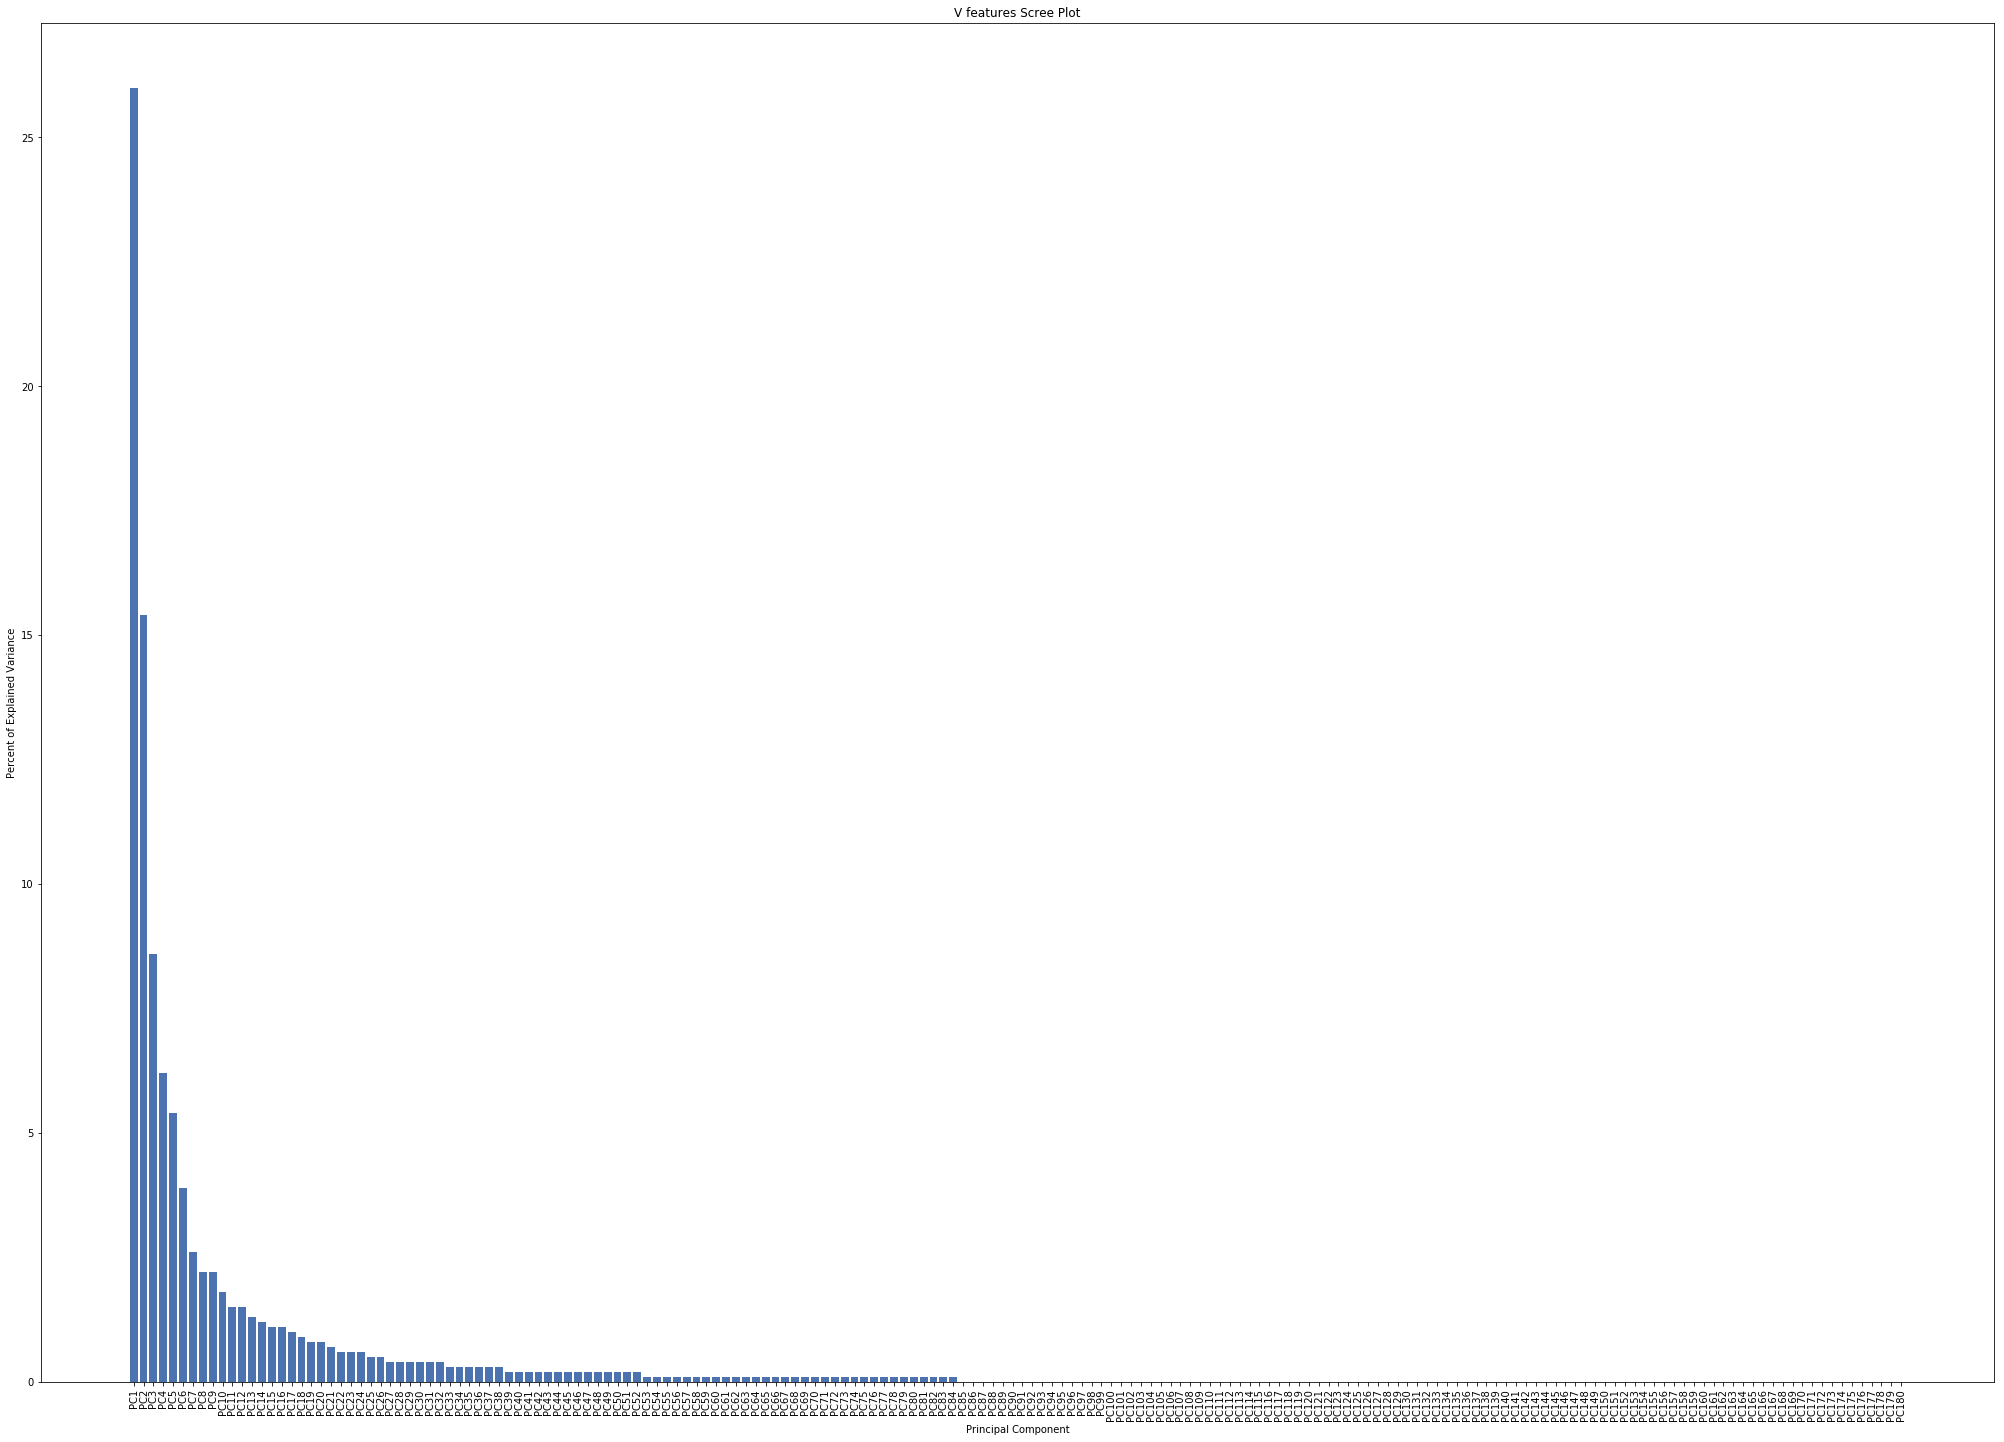

In [247]:
from matplotlib.pyplot import figure
plt.figure(figsize=(26,16))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks(rotation='vertical')
plt.ylabel('Percent of Explained Variance')
plt.xlabel('Principal Component')
plt.title('V features Scree Plot')
plt.show()

### Try different balancing techniques, runnning pca afterwards, and running exclusively on the V columns to see which performs best in terms of Precision and Recall, and F1 score. Choose the best afterwards.

### Re-tune n_nighbors in imputing process using Iterative Imputer.

### Re-tune k_nighbors in balancing process.

### Normalizing target

In [ ]:
train_transaction['v_mean'] = train_transaction[v_cols].mean(axis=1)
train_transaction.loc[train_transaction['isFraud'] == 1]['v_mean'].apply(np.log) 
train_transaction.loc[train_transaction['isFraud'] == 0]['v_mean'].apply(np.log) 

# Identity EDA

In [ ]:
i_cols = [c for c in train_transaction if c[0] == 'i']

## Try out SHAP and LIME if you have the time